### TMA4320 - Project 2: Physics


# 0.0 Motivation

In [309]:

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tempfile import TemporaryFile

# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [310]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)

A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)

In [311]:
def calculate_I_c(m, R):
    return 0.5*m*(R**2)*(1-(32/(9*(np.pi**2))))

m = A_s*sigma
I_c = calculate_I_c(m, R)

In [312]:
def calculate_beta(rhs_constant, x0, tol=1.e-8, max_iter=50):
    ''' Given a right hand side and left hand side of a function and its derivatives, calculates the beta value of the function.
    
    Solve f(x)=0 by Newtons method, 
    
        The output of each iteration is printed
        Input:
        f_lhs: left hand side of function
        df_lhs: left hand side of derivative of function
        f_rhs: right hand side of function
        df_rhs: right hand side of derivative of function
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''

    f = lambda beta: beta - np.sin(beta) - rhs_constant
    df = lambda beta: 1 - np.cos(beta)


    x = x0
    print(f"k ={0:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
        print(f"k ={k+1:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    return x

In [313]:
def excercise_1a():
    f_lhs = lambda beta: beta-np.sin(beta)
    df_lhs = lambda beta: 1 - np.cos(beta)

    f_rhs = lambda beta : np.pi * sigma/sigma_0
    df_rhs = 0

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    print(beta)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")

excercise_1a()

beta = 132.3464590340394
beta = np.radians(beta)


#Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = R*np.cos(beta/2)
y_C_0 = y_M_0 - 4*R/(3*np.pi)
y_B_0 = y_M_0 - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = y_M_0 - R

#Values as functions of delta y_C and theta. 
y_M = lambda theta, delta_y_C : y_M_0 + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda delta_y_c : y_C_0 + delta_y_c
y_D = lambda theta, delta_y_c : y_D_0 + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = y_B_0

#Note: beta is a global variable
gamma = lambda theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

water_area = lambda gamma: 0.5*(R**2)*(gamma - np.sin(gamma))

F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g
friction = lambda k_f,omega,gamma : -k_f * R * gamma*omega

k =  0, x =  5.000000000000000, f(x) =  4.388e+00
k =  1, x = -1.125780126106932, f(x) = -1.794e+00
k =  2, x =  2.024151652930856, f(x) = -4.456e-01
k =  3, x =  2.334048802844800, f(x) =  4.066e-02
k =  4, x =  2.310007184357851, f(x) =  2.104e-04
k =  5, x =  2.309881463499782, f(x) =  5.840e-09
2.309881463499782
Beta =  132.35 degrees


## 0.? Visualisering av data

For å analysere opparbeidete resultater er det hensiktsmessig å visualisere det i plot. Derfor definerer vi en fleksibel funksjon som plotter datasett på en foretrukket måte. Denne vil bli brukt gjennomgående i rapporten.


# 1.3 Euler metoden


In [314]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    w_new = w + h_step*f(t, w)
    return t,w_new

In [315]:
def solve_ODE(f, t_0, t_end, w_0, h_step, method):
    '''
    Funksjon som løser diff-liking ved å benytte Euler-metoden.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_step: steglengde
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    w_num = np.array([w_0])  
    t_num = np.arange(t_0, t_end + h_step, h_step)   
    t,w_n = method(f, t_num[0], w_num[0], h_step)
    w_num = np.concatenate((w_num, np.array([w_n])))
    for i in range(1,len(t_num)-1):#ikke inkl første element
        if t_num[-1] > t_end- 1.0e-10: #For å treffe endepunktet. 10e-10 for å unngå "truncation error"
            t_num[-1] = t_end
        
        t,w_n = method(f, t_num[i], w_num[i], h_step)
        # print(w_n)
        theta_n = w_n[0]
        # print(w_num)
        y_n = w_num[:,3] 
        # print(y_n)
        # print(y_n[-2])
        # print(y_n[-1])
        delta_y_n= y_n[-2]-y_n[-1]
        
        delta_y_c_n = y_C(delta_y_n)
        print(theta_n)
        if theta_n > 0.5*(np.pi-gamma(theta_n,delta_y_c_n,)): #Sjekk om båten kantrer
            w_n[0] = np.pi/2 * np.sign(w_num[0,-1]) #Forrige theta-element 
            for i in range(1,len(w_n)):
                w_n[i]=0

        
        w_num = np.concatenate((w_num, np.array([w_n])))
    #print(t_num)
    return t_num, w_num

The function can be calculated by 

In [316]:
def f(t, w):
    const = (A_0 * sigma_0 * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

In [317]:
def plot(theta_0,omega_0,t_0,t_end,h_step,method):
    return 0

Equating the...

In [318]:
def test_euler():
    theta_0 = np.radians(20)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step,euler_step)

    theta_num = w_num[:,0]
    omega_num = w_num[:,1]


    plt.plot(t_num, theta_num, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()

## Small angle approximation
...

In [319]:
def f(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

def f_small_angle(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*w[0]])

In [320]:
def angle_approx_comparison():

    theta_0 = np.radians(10)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step,euler_step)
    t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)


    theta_num = w_num[:,0]
    omega_num = w_num[:,1]
    theta_num_small_angle_approx = w_num_small_angle_approx[:,0]
    omega_num_small_angle_approx = w_num_small_angle_approx[:,1]

    diff = theta_num_small_angle_approx - theta_num    


    plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
    plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
    #plt.plot(t_num, diff, label = "Differanse")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.2,0.2)        
    plt.legend(loc=3, shadow = True)
    plt.show()

#angle_approx_comparison()

## 1.3 Runge Kutta metoden

Implementerer fjerde ordens Runge Kutta.


In [321]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h

    return t_new, w_new




In [322]:

def f(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

In [323]:
def test_runge_kutta():
    theta_0 = np.radians(20)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)

    theta_num_rk4 = w_num_rk4[:,0]
    omega_num_rk = w_num_rk4[:,1]


    plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()
    

#test_runge_kutta()

## 1h)
...


In [324]:
def f_analytic(t):
    return 0.01*np.cos(np.sqrt((m*g*h)/I_c)*t)


# To be used in numerical solutions
def f_small_angle(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*w[0]])
def f_not_small_angle(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*  np.sin(w[0])])

In [325]:
def anal_vs_num():
    theta_0 = np.radians(0.01)
    omega_0 = 0
    w_0 = np.array([theta_0, omega_0])

    t_0 = 0
    t_end = 20

    f_analytic_t_20 = f_analytic(20)

    # Antar det er snakk om h som steglengde
    h_steps = np.linspace(0.01, 3, 1000)

    theta_t20_arr_euler = np.array([])
    theta_t20_arr_rk4 = np.array([])


    for i in range(len(h_steps)):
        result_euler = solve_ODE(f_small_angle, t_0, t_end, w_0, h_steps[i], euler_step)
        result_rk4 = solve_ODE(f_small_angle, t_0, t_end, w_0, h_steps[i], rk4_step)
        theta_t20_arr_euler =np.append(theta_t20_arr_euler, result_euler[1][:,0][-1])
        theta_t20_arr_rk4 = np.append(theta_t20_arr_rk4 ,result_rk4[1][:,0][-1])


    difference_euler = theta_t20_arr_euler-f_analytic_t_20
    difference_rk4 = theta_t20_arr_rk4-f_analytic_t_20
    difference_rk4 = np.abs(difference_rk4)


###############################

    #plt.yscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, difference_euler, label = "Euler")
    plt.plot(h_steps, difference_rk4, label = "RK4")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    #plt.ylim(-0.2,0.2)        
    plt.legend(loc=2, shadow = True)
    plt.show()


    plt.yscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, difference_euler, label = "Euler")
    plt.plot(h_steps, difference_rk4, label = "RK4")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')

    plt.legend(loc=2, shadow = True)
    plt.show()



###############################


    # print(f_analytic_t_20)
    # x_axis = np.linspace(0,20,len(theta_t20_arr_rk4))
    # plt.plot(x_axis,theta_t20_arr_euler)
    # plt.show()




    plt.yscale("log")

    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0

    plt.plot(h_steps, difference_rk4, label = "RK4")
    print()

    plt.title("Differansen mellom den analytiske og de numeriske løsningene ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    # plt.ylim(-0.2,0.2)                
    plt.legend(loc=2, shadow = True)
    plt.show()

#anal_vs_num()

## 2b

In [326]:
# w[0] = theta
# w[1] = omega
# w[2] = x
# w[3] = y
# w[4] = v_x
# w[5] = v_y


def f(t, w):  
    '''
    Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
    Inn:
        t: float, tid
        w: s-array, beskriver diverse av systemets fysiske egenskaper
    Ut:
        w-arrayet med oppdaterte verdier
    
    '''
    
    
    delta_y_c_current = w[3] - y_C_0   
    gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

    A = water_area(gamma_current)
    return np.array([w[1], -((F_B(A) * h)/I_c)*np.sin(w[0]), w[4], w[5], 0, (F_G(m) + F_B(A))/m])

0.36641969091475995
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


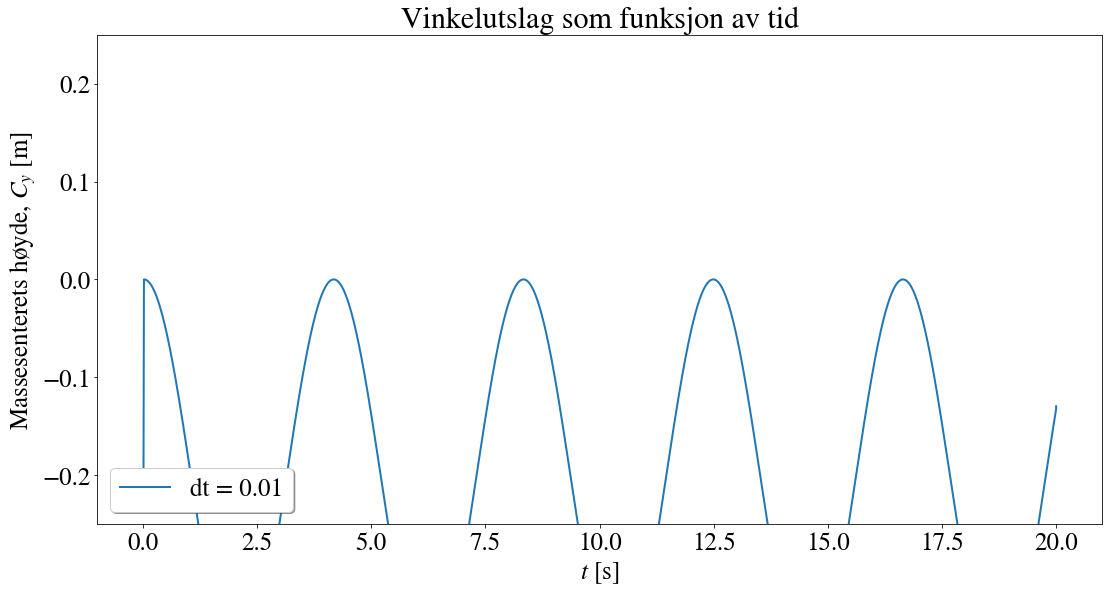

In [328]:
def cm_plot():
    theta_0 = np.radians(21)
    omega_0 = 0
    x_C_0 = 0
    v_x_0 = 0
    v_y_0 = 0

    w_0 = np.array([theta_0, omega_0, x_C_0, y_C_0, v_x_0, v_y_0])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)

    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    y_num_rk4 = w_num_rk4[:,3]
    omega_num_rk = w_num_rk4[:,1]
    theta_num_rk4 = w_num_rk4[:,0]
    x_C_num_rk4 = w_num_rk4[:,2]
    y_C_num_rk4 = w_num_rk4[:,3]
    

    plt.plot(t_num_rk4, y_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

cm_plot()

# X.0 Conclusion

Lorem Ipsum...